In [145]:
import pickle
import h5py
import matplotlib.pyplot as plt
import random
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import StratifiedKFold
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [146]:
# Load dataset from h5 files
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
X_train_orig = train_dataset["train_set_x"][:]
Y_train_orig = train_dataset["train_set_y"][:]

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
X_test_orig = test_dataset["test_set_x"][:]
Y_test_orig = test_dataset["test_set_y"][:]

classes = test_dataset["list_classes"][:]

Y_test_orig = 1 - Y_test_orig
Y_train_orig = 1 - Y_train_orig
print(Y_test_orig.shape) 
print(Y_train_orig.shape)

(50,)
(209,)


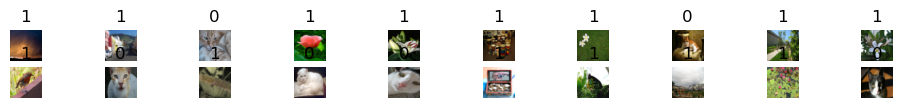

In [147]:
# Display sample images
images_iter = iter(X_train_orig)
labels_iter = iter(Y_train_orig)
plt.figure(figsize=(12, 12))
for i in range(20):
    ax = plt.subplot(25, 10, i + 1)
    current_image = next(images_iter)
    current_label = next(labels_iter)
    plt.imshow(current_image.astype("uint8"))
    plt.title(current_label.astype("uint8"))
    plt.axis("off")

In [166]:
# Data preprocessing
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

print("Number of training examples = " + str(X_train.shape[0]))
print("Number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))


def convolutional_model(input_shape):
    # Define the convolutional model architectur
    input_img = tf.keras.Input(shape=input_shape, name='tf_input')
    Z1 = tf.keras.layers.Conv2D(8, 4, strides=(1, 1), padding='same', input_shape=input_shape)(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(16, 2, strides=(1, 1), padding='same', input_shape=input_shape)(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(F)
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

# Create and compile the convolutional model

conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
conv_model.summary()

Number of training examples = 209
Number of test examples = 50
X_train shape: (209, 64, 64, 3)
Y_train shape: (209, 1)
X_test shape: (50, 64, 64, 3)
Y_test shape: (50, 1)


Model: "functional_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tf_input (InputLayer)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 64, 64, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_117 (ReLU)                │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 8, 8, 8)        │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 8, 8, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_118 (ReLU)                │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_122               │ (None, 2, 2, 16)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_100 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985 (3.85 KB)

 Trainable params: 985 (3.85 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=120, validation_data=test_dataset)

Epoch 1/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6388 - loss: 0.6759 - val_accuracy: 0.3400 - val_loss: 0.7746
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6591 - loss: 0.6451 - val_accuracy: 0.3400 - val_loss: 0.8430
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6338 - val_accuracy: 0.3400 - val_loss: 0.8962
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6591 - loss: 0.6329 - val_accuracy: 0.3400 - val_loss: 0.9160
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6326 - val_accuracy: 0.3400 - val_loss: 0.9073
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6301 - val_accuracy: 0.3400 - val_loss: 0.8859
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6267 - val_accuracy: 0.3400 - val_loss: 0.8661
Epoch 8/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6236 - val_accuracy: 0.3400 - val_loss:

/var/folders/_1/y199p3xd06q8rxpp5cgxqq5m0000gq/T/ipykernel_46939/973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/_1/y199p3xd06q8rxpp5cgxqq5m0000gq/T/ipykernel_46939/973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

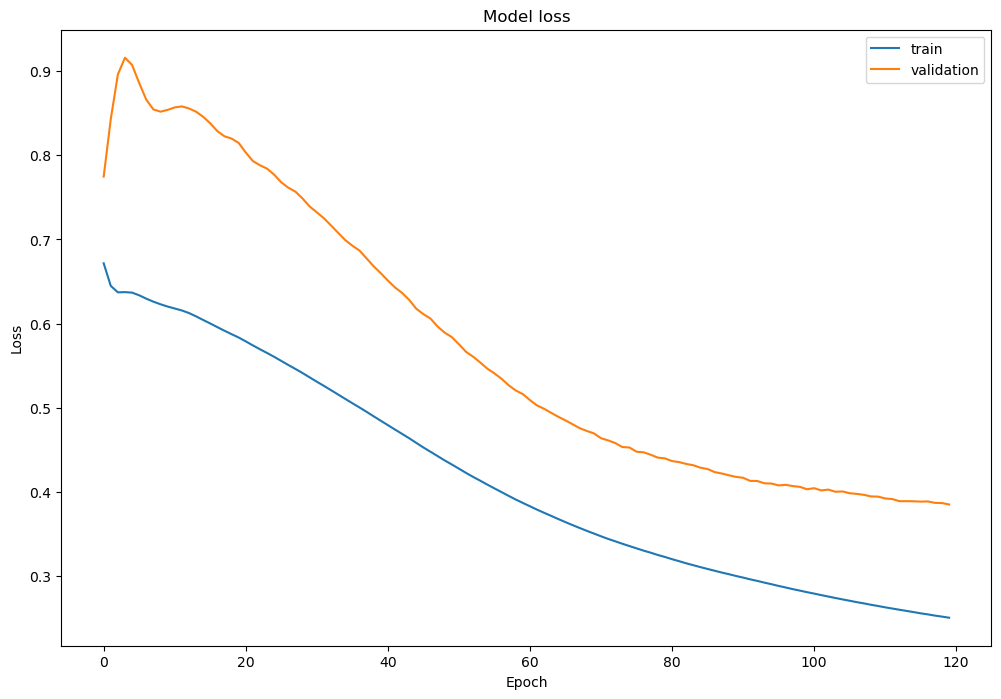

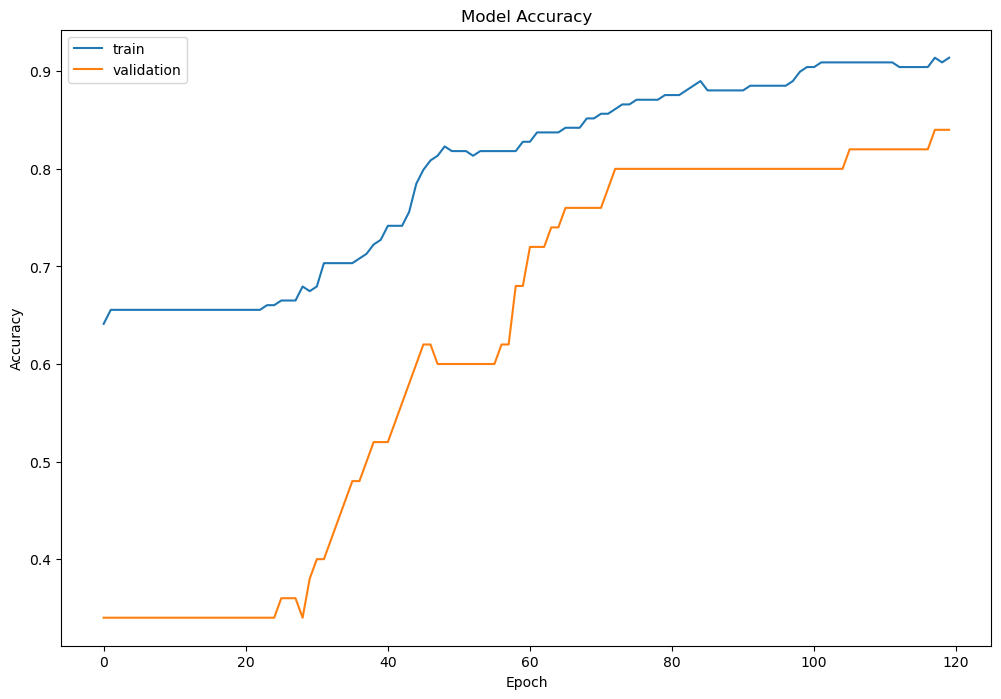

In [168]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [158]:
class Average_Saliency(object):
    def __init__(self, model, output_index=0):
        pass
    def get_grad(self, input_image):
        pass
    def get_average_grad(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))
        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise
            total_gradients += self.get_mask(x_value_plus_noise)
        return total_gradients / nsamples
class Single_Saliency(Average_Saliency):
    def __init__(self, model, output_index=0):
        # Define the function to compute the gradient
        self.model = model
        self.output_index = output_index
    def get_grad(self, input_image):
        # Execute the function to compute the gradient
        #input_tensor = tf.expand_dims(input_image, axis=0)
        input_tensor = input_image
        input_tensor = tf.Variable(tf.cast(input_tensor, tf.float64))  # Convert input tensor data type to float32
        with tf.GradientTape() as tape:
            output = self.model(input_tensor)
            loss = output[0, self.output_index] 
        gradients = tape.gradient(loss, input_tensor)
        return gradients[0].numpy()

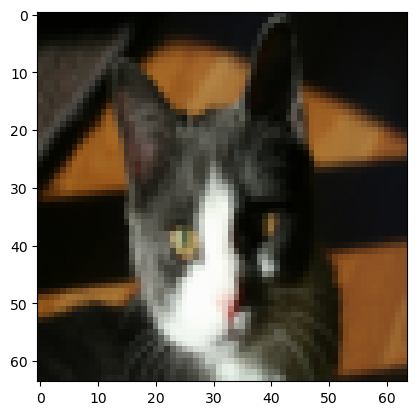

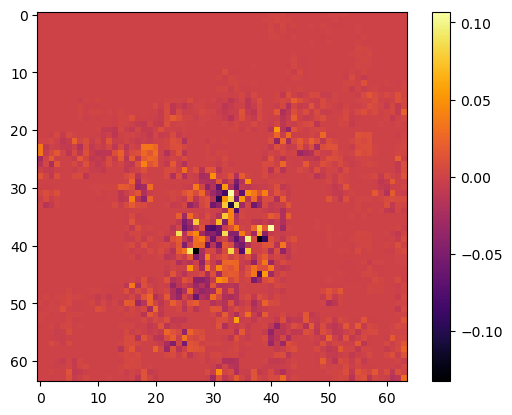

In [169]:
single = Single_Saliency(conv_model)
grad_control = single.get_grad(tf.expand_dims(current_image/255.0, axis = 0))
#filter_grad = (grad > 0.0).reshape((64, 64, 3))
#average_grad = single.get_average_grad(current_image)
#filter_average_grad = (average_grad > 0.0).reshape((28, 28))

plt.imshow(current_image.reshape((64, 64, 3)), cmap = 'gray')
plt.show()
#plt.imshow(grad.reshape((64, 64, 3)), cmap = 'jet')
plt.imshow(np.sum(grad_control.reshape((64, 64, 3)), axis=2), cmap='inferno', interpolation='nearest')
plt.colorbar() 
plt.show()

In [170]:
# Quick check of the model using an image
reshaped_x = current_image / 255.0  # Normalize the input image
reshaped_x = np.expand_dims(reshaped_x, axis=0)  # Add a batch dimension
# Verify the shape of the input data after processing
print(reshaped_x.shape)
# Make predictions using the trained model
predictions = conv_model.predict(reshaped_x)
print(predictions)

(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.33487898]]


In [171]:
def tiny_convolutional_model(input_shape):
    # Define the convolutional model architectur
    input_img = tf.keras.Input(shape=input_shape, name='tf_input')
    Z1 = tf.keras.layers.Conv2D(8, 4, strides=(2, 2), padding='same', input_shape=input_shape)(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=(10, 10), padding='same')(A1)
    F = tf.keras.layers.Flatten()(P1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(F)
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tf_input (InputLayer)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 32, 32, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_91 (ReLU)                 │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_73 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6591 - loss: 0.6416 - val_accuracy: 0.3400 - val_loss: 0.8882
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6333 - val_accuracy: 0.3400 - val_loss: 0.8746
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6295 - val_accuracy: 0.3400 - val_loss: 0.8748
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6261 - val_accuracy: 0.3400 - val_loss: 0.8776
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6230 - val_accuracy: 0.3400 - val_loss: 0.8781
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6591 - loss: 0.6204 - val_accuracy: 0.3400 - val_loss: 0.8745
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6179 - val_accuracy: 0.3400 - val_loss: 0.8683
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6591 - loss: 0.6153 - val_accuracy: 0.3400 - val_loss: 0.860

/var/folders/_1/y199p3xd06q8rxpp5cgxqq5m0000gq/T/ipykernel_46939/792217778.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/_1/y199p3xd06q8rxpp5cgxqq5m0000gq/T/ipykernel_46939/792217778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

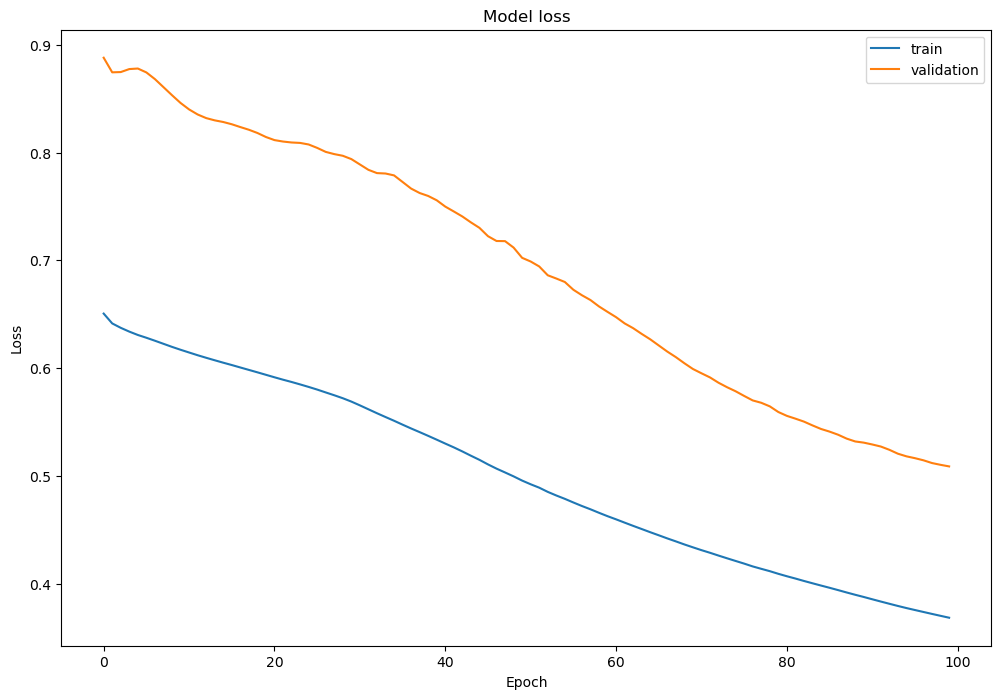

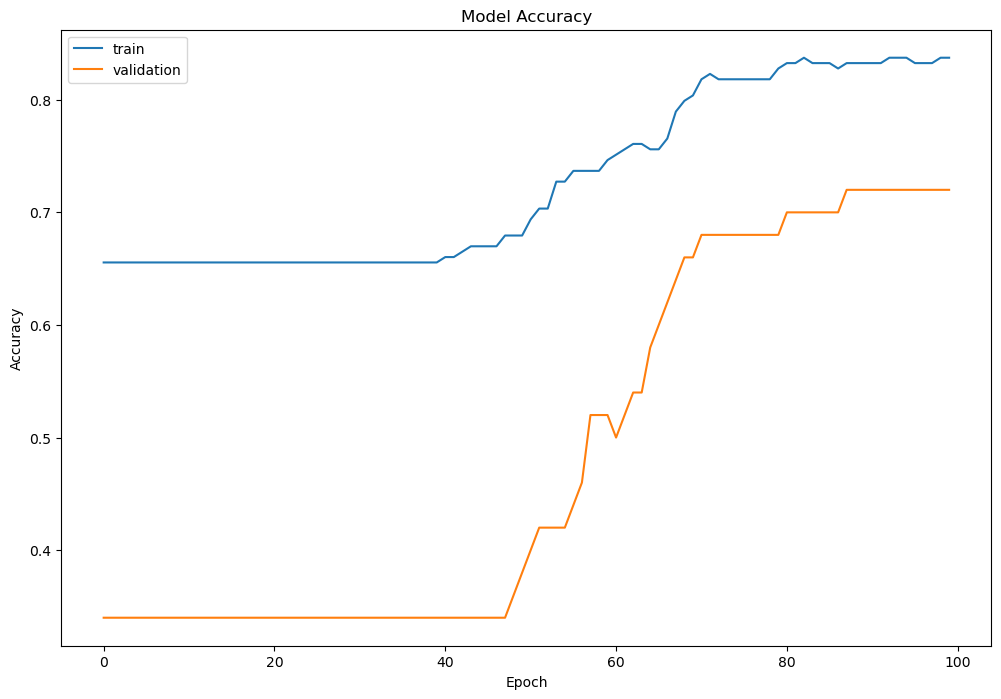

In [115]:
tconv_model = tiny_convolutional_model((64, 64, 3))
tconv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tconv_model.summary()
history = tconv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [125]:
def network_in_network_model(input_shape):
    # Define the convolutional model architecture
    input_img = tf.keras.Input(shape=input_shape, name='tf_input')
    #Z1 = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', input_shape=input_shape)(input_img)
    Z1 = tf.keras.layers.Conv2D(192, 5, padding='same')(input_img)
    Z1 = tf.keras.layers.BatchNormalization()(Z1)
    Z1 = tf.keras.layers.Activation('relu')(Z1)
    
    Z1 = tf.keras.layers.Conv2D(160, 1, activation='relu', padding='same')(Z1)
    Z1 = tf.keras.layers.Conv2D(96, 1, activation='relu', padding='same')(Z1)
    Z1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(Z1)
    Z1 = tf.keras.layers.Dropout(0.5)(Z1)
    Z2 = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', input_shape=input_shape)(Z1)
    Z2 = tf.keras.layers.Conv2D(192, 1, activation='relu', padding='same')(Z2)
    Z2 = tf.keras.layers.Conv2D(192, 1, activation='relu', padding='same')(Z2)
    Z2 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=2)(Z2)
    Z2 = tf.keras.layers.Dropout(0.5)(Z2)
    Z3 = tf.keras.layers.Conv2D(192, 3, activation='relu', padding='same', input_shape=input_shape)(Z2)
    Z3 = tf.keras.layers.Conv2D(192, 1, activation='relu', padding='same')(Z3)
    Z3 = tf.keras.layers.Conv2D(2, 1, activation='relu', padding='same')(Z3)
    #Z3 = tf.keras.layers.Conv2D(2, 1, padding='same')(Z3)
    #Z3 = tf.keras.layers.BatchNormalization()(Z3)
    #Z3 = tf.keras.layers.Activation('relu')(Z3)
    
    Z3 = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(Z3)
    Z4 = tf.keras.layers.Flatten()(Z3)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(Z4)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [127]:
# Compile the model
nin_model = network_in_network_model((64, 64, 3))
nin_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nin_model.summary()
# Fit the model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = nin_model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tf_input (InputLayer)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 64, 64, 192)    │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 64, 64, 160)    │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 64, 64, 96)     │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 31, 31, 192)    │       460,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 31, 31, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 31, 31, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 15, 15, 192)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 15, 15, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 15, 15, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 15, 15, 2)      │           386 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 3, 3, 2)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_78 (Flatten)            │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,229 (3.69 MB)

 Trainable params: 965,845 (3.68 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 924ms/step - accuracy: 0.6209 - loss: 0.6906 - val_accuracy: 0.3400 - val_loss: 0.7006
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 858ms/step - accuracy: 0.6591 - loss: 0.6059 - val_accuracy: 0.3400 - val_loss: 0.6972
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 868ms/step - accuracy: 0.6591 - loss: 0.5667 - val_accuracy: 0.3400 - val_loss: 0.6968
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 909ms/step - accuracy: 0.6620 - loss: 0.5128 - val_accuracy: 0.3200 - val_loss: 0.6922
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 842ms/step - accuracy: 0.6601 - loss: 0.4810 - val_accuracy: 0.7400 - val_loss: 0.6919
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 871ms/step - accuracy: 0.6620 - loss: 0.4469 - val_accuracy: 0.7200 - val_loss: 0.6922
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 871ms/step - accuracy: 0.6971 - loss: 0.4296 - val_accuracy: 0.7000 - val_loss: 0.6924
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 873ms/step - accuracy: 0.7034 - loss: 0.4108 - val_accuracy: 0.6600 - val_loss:

In [175]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
@tf.function

def attention_transfer_loss_cosine_similarity(teacher_saliency_map, student_saliency_map):
    # Ensure tensors are float32
    teacher_saliency_map = tf.cast(teacher_saliency_map, tf.float32)
    student_saliency_map = tf.cast(student_saliency_map, tf.float32)
    # Compute dot product and magnitudes
    dot_product = tf.reduce_sum(teacher_saliency_map * student_saliency_map, axis=[1,2,3])
    magnitude_teacher = tf.sqrt(tf.reduce_sum(tf.square(teacher_saliency_map), axis=[1,2,3]))
    magnitude_student = tf.sqrt(tf.reduce_sum(tf.square(student_saliency_map), axis=[1,2,3]))
    # Compute cosine similarity
    cosine_similarity = dot_product / (magnitude_teacher * magnitude_student + 1e-8)  # Adding epsilon for numerical stability
    return -tf.reduce_mean(cosine_similarity)

@tf.function

def attention_transfer_loss_top10_euclidean_distance_both(teacher_saliency_map, student_saliency_map):
    # Ensure tensors are float32
    teacher_saliency_map = tf.cast(teacher_saliency_map, tf.float32)
    student_saliency_map = tf.cast(student_saliency_map, tf.float32)
    # Flatten the spatial dimensions
    batch_size = tf.shape(teacher_saliency_map)[0]
    teacher_flat = tf.reshape(teacher_saliency_map, [batch_size, -1])
    student_flat = tf.reshape(student_saliency_map, [batch_size, -1])
    num_pixels = tf.shape(teacher_flat)[1]
    num_top_values = tf.cast(0.02 * tf.cast(num_pixels, tf.float32), tf.int32)
    num_bottom_values = tf.cast(0.01 * tf.cast(num_pixels, tf.float32), tf.int32)
    # Use top_k for top values
    top_values, _ = tf.math.top_k(teacher_flat, k=num_top_values, sorted=True)
    # For bottom values, get the smallest k values by negating
    bottom_values, _ = tf.math.top_k(-teacher_flat, k=num_bottom_values, sorted=True)
    bottom_values = -bottom_values  # Revert to original values
    # Gather corresponding student values
    # To find indices, use argsort
    sorted_indices = tf.argsort(teacher_flat, axis=1, direction='ASCENDING')
    top_indices = sorted_indices[:, -num_top_values:]
    bottom_indices = sorted_indices[:, :num_bottom_values]
    # Use batch gather
    batch_indices = tf.reshape(tf.range(batch_size), [-1, 1])
    batch_indices = tf.tile(batch_indices, [1, num_top_values])
    top_gather_indices = tf.stack([batch_indices, top_indices], axis=-1)
    student_top_values = tf.gather_nd(student_flat, top_gather_indices)
    batch_indices_bottom = tf.reshape(tf.range(batch_size), [-1, 1])
    batch_indices_bottom = tf.tile(batch_indices_bottom, [1, num_bottom_values])
    bottom_gather_indices = tf.stack([batch_indices_bottom, bottom_indices], axis=-1)
    student_bottom_values = tf.gather_nd(student_flat, bottom_gather_indices)
    # Calculate Euclidean distance for top and bottom values
    euclidean_top = tf.sqrt(tf.reduce_sum(tf.square(top_values - student_top_values), axis=1))
    euclidean_bottom = tf.sqrt(tf.reduce_sum(tf.square(bottom_values - student_bottom_values), axis=1))
    # Total loss
    total_euclidean_distance = tf.reduce_mean(euclidean_top + euclidean_bottom)
    return total_euclidean_distance

# Precompute teacher saliency maps using vectorized operations

teacher_saliency_map = []
for batch_inputs, batch_labels in train_dataset:
    with tf.GradientTape() as tape:
        tape.watch(batch_inputs)
        teacher_outputs = conv_model(batch_inputs, training=True)
        teacher_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(batch_labels, teacher_outputs))
    teacher_grads = tape.gradient(teacher_loss, batch_inputs)
    teacher_saliency_map.append(teacher_grads)

# Define and compile the student model
conv_model2 = tiny_convolutional_model((64, 64, 3))
conv_model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Optimizer
optimizer = tf.keras.optimizers.Adam()
# Training loop with @tf.function for graph execution

@tf.function

def train_step(conv_model, batch_inputs, batch_labels, teacher_saliency):
    with tf.GradientTape() as tape:
        # Forward pass for student
        student_outputs = conv_model(batch_inputs, training=True)
        
        student_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(batch_labels, student_outputs)
        )

        # Compute student saliency maps
        with tf.GradientTape() as tape_student:
            tape_student.watch(batch_inputs)
            student_outputs = conv_model(batch_inputs, training=True)
            student_loss_inner = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(batch_labels, student_outputs)
            )
        student_grads = tape_student.gradient(student_loss_inner, batch_inputs)

        # Compute attention loss
        att_loss = attention_transfer_loss_top10_euclidean_distance_both(teacher_saliency, student_grads)*20

        # Total loss
        total_loss = student_loss + att_loss

    # Compute gradients and apply
    gradients = tape.gradient(total_loss, conv_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, conv_model.trainable_variables))
    return total_loss, student_loss, att_loss


# Training loop
EPOCHS = 120
for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}/{EPOCHS}")
    batch_index = 0
    for batch_inputs, batch_labels in train_dataset:
        # Fetch precomputed teacher saliency map
        teacher_saliency = teacher_saliency_map[batch_index]
        # Perform a training step
        total_loss, student_loss, att_loss = train_step(conv_model2, batch_inputs, batch_labels, teacher_saliency)
        if batch_index % 100 == 0:
            print(f"Batch {batch_index}: Total Loss: {total_loss.numpy()}, "
                  f"Student Loss: {student_loss.numpy()}, Attention Loss: {att_loss.numpy()}")
        batch_index += 1
    # Evaluation on test dataset
    test_loss = 0.0
    test_accuracy = 0.0
    num_batches = 0
    for test_inputs, test_labels in test_dataset:
        test_outputs = conv_model2(test_inputs, training=False)
        
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(test_labels, test_outputs))
        accuracy = tf.reduce_mean(
            tf.keras.metrics.binary_accuracy(test_labels, test_outputs)
        )
        test_loss += student_loss
        test_accuracy += accuracy
        num_batches += 1
    test_loss /= num_batches
    test_accuracy /= num_batches
    print(f'Epoch {epoch + 1}, Test Loss: {test_loss.numpy():.4f}, Test Accuracy: {test_accuracy.numpy():.2%}')
    '''if test_accuracy.numpy() > 0.85:
        print("Reached target accuracy. Stopping training.")
        break'''

Starting epoch 1/120
Batch 0: Total Loss: 0.9625322818756104, Student Loss: 0.6793612241744995, Attention Loss: 0.2831710875034332
Epoch 1, Test Loss: 0.6660, Test Accuracy: 34.00%
Starting epoch 2/120
Batch 0: Total Loss: 0.9099554419517517, Student Loss: 0.6281365156173706, Attention Loss: 0.2818189263343811
Epoch 2, Test Loss: 0.6075, Test Accuracy: 34.00%
Starting epoch 3/120
Batch 0: Total Loss: 0.8862956762313843, Student Loss: 0.6050911545753479, Attention Loss: 0.28120455145835876
Epoch 3, Test Loss: 0.5749, Test Accuracy: 34.00%
Starting epoch 4/120
Batch 0: Total Loss: 0.8811566233634949, Student Loss: 0.6005791425704956, Attention Loss: 0.28057748079299927
Epoch 4, Test Loss: 0.5618, Test Accuracy: 34.00%
Starting epoch 5/120
Batch 0: Total Loss: 0.8817760944366455, Student Loss: 0.6015246510505676, Attention Loss: 0.28025147318840027
Epoch 5, Test Loss: 0.5583, Test Accuracy: 34.00%
Starting epoch 6/120
Batch 0: Total Loss: 0.880781352519989, Student Loss: 0.600762367248535